In [1]:
import numpy as np
import pandas as pd
import pickle

### pickle file is generated by the application itself. Original csv file is imported into dataframe with some location information and then pickled.

In [2]:
file = open("temp_model.pickle",'rb')
df = pickle.load(file)
df.head()

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE


In [3]:
df.dtypes

DWG Number          object
RLocation           object
Tag                 object
Area               float64
Type                object
Loop Number        float64
Location           float64
Description         object
Manufacturer       float64
Model Number       float64
Comment            float64
Class Name          object
PnPID                int64
Area No            float64
Unit No            float64
Supplied By         object
Status              object
Sequence Number    float64
Suffix              object
Instrument Spec    float64
Spec Issued        float64
PO Issued          float64
Signal Type 1       object
Signal Type 2       object
Signal Type 3       object
dtype: object

In [4]:
lats = []
lons = []

for row in df['RLocation']:
    if type(row) != str:
        lat,lon = (None,None)
    else:
        lat,lon = tuple(str(row).split(','))
        lat = int(lat)
        lon = int(lon)
    lats.append(lat)
    lons.append(lon)
df["Lat"] = lats
df["Long"] = lons 

In [5]:
df['RLocation'].notna().head(20)

0      True
1      True
2     False
3      True
4     False
5      True
6      True
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17    False
18     True
19    False
Name: RLocation, dtype: bool

In [6]:
df_located = df[['RLocation','Lat','Long']][df['RLocation'].notna()]

In [7]:
df_located.describe()

,Lat,Long
count,97.000000,97.000000
mean,376.824742,292.587629
std,150.514673,190.005688
min,266.000000,83.000000
25%,294.000000,117.000000
50%,300.000000,158.000000
75%,535.000000,557.000000
max,774.000000,564.000000


In [8]:
X = np.array(df_located)
X = X[:,1:3]

In [9]:
X[:20]

array([[298.0, 561.0],
       [300.0, 561.0],
       [299.0, 562.0],
       [300.0, 561.0],
       [301.0, 562.0],
       [302.0, 563.0],
       [301.0, 564.0],
       [301.0, 564.0],
       [299.0, 563.0],
       [771.0, 289.0],
       [771.0, 291.0],
       [773.0, 292.0],
       [774.0, 293.0],
       [774.0, 292.0],
       [773.0, 292.0],
       [773.0, 292.0],
       [534.0, 315.0],
       [537.0, 318.0],
       [536.0, 316.0],
       [535.0, 318.0]], dtype=object)

### With the location tagging tool used in Tkinter, variation of the location information is introduced by the operator. Instrument Tags location could be contain slight variation of location but is designated to what is meant to be the same exact location. With the semi-filled locations, we will first use a cluster algorithm to group labeled location into its mean location. This effectively bin the exact tagged location for each instrument tag into process units. 

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


Estimated number of clusters: 7
Estimated number of noise points: 0


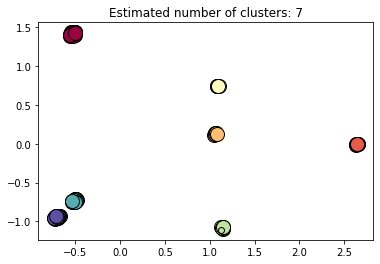

In [11]:
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
# Higher min_samples or lower eps indicate higher density necessary to form a cluster.
db = DBSCAN(eps=0.03, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [12]:
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### With the small adjustment in eps(cluster radius) and min_sample(minimum cluster size) we were able to group locations into clusters that represent unit. This allow us to bin the locations into each unit.

In [13]:
df_located["unit_label"] = db.labels_

In [14]:
df_located.index

Int64Index([  0,   1,   3,   5,   6,   8,  16,  18,  21,  27,  28,  29,  31,
             32,  33,  38,  44,  45,  46,  47,  51,  54,  55,  61,  62,  63,
             64,  65,  66,  79,  81,  83,  84,  85,  92,  96, 100, 101, 102,
            103, 104, 105, 118, 122, 123, 124, 135, 136, 137, 141, 142, 155,
            173, 176, 177, 179, 189, 197, 198, 199, 200, 202, 203, 206, 208,
            209, 210, 236, 237, 240, 241, 242, 243, 266, 267, 268, 269, 271,
            279, 287, 291, 295, 297, 299, 300, 303, 304, 307, 308, 309, 322,
            324, 325, 326, 328, 332, 337],
           dtype='int64')

In [15]:
df["unit_label"] = None
df.iloc[df_located.index, -1] = db.labels_

In [16]:
pd.set_option('display.max_rows',100)
df.iloc[:,[0,1,-1]][df["RLocation"].notna()]

,DWG Number,RLocation,unit_label
0,PID-143,"298,561",0
1,PID-143,"300,561",0
3,PID-143,"299,562",0
5,PID-143,"300,561",0
6,PID-143,"301,562",0
8,PID-143,"302,563",0
16,PID-143,"301,564",0
18,PID-143,"301,564",0
21,PID-143,"299,563",0
27,PID-101,"771,289",1


#### We can now use unit_label enumeration as a target variable. This effectively bined the locations into categorical variables. We can use these labeled location now as training set for the machine learning algorithm to classify each intrument tags into the location. In this data set, this will be trivial since P&ID number is tied directly 1 to 1 with the location. None the less, we can mix other attributes in and provide a general framework for predicting the location of the instrument tag.

In [17]:
groupby_unit_label_Lat = df[df['Lat'].notnull()].groupby('unit_label').mean()[['Lat','Long']]

In [18]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat':'Lat_mean','Long':'Long_mean'})

In [19]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'unit_label')

In [20]:
df_encoded = pd.get_dummies(df[['DWG Number','Type','Description','Suffix','Signal Type 1']], prefix=['DWG','Type','Description','Suffix','Signal Type 1'])

### We assign the centroid or the mean of each cluster into its respective row.

In [21]:
df.iloc[:,15:]

,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,With assembly,NaN,3.0,G,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,With assembly,NaN,5.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,NaN,NaN,4.0,E,NaN,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,With assembly,NaN,3.0,J,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [22]:
df_numeric = df[['Area No','Unit No','Sequence Number']]
df_numeric

,Area No,Unit No,Sequence Number
0,20.0,77.0,53.0
1,20.0,41.0,1.0
2,20.0,41.0,1.0
3,20.0,41.0,2.0
4,20.0,41.0,1.0
...,...,...,...
347,20.0,41.0,3.0
348,20.0,41.0,5.0
349,20.0,41.0,4.0
350,20.0,41.0,3.0


### We encode the categorical variables and merge back with the numberical variables

In [23]:
normalized_df = df_encoded.merge(df_numeric,left_index=True, right_index=True)

In [24]:
normalized_df.iloc[:,-40:].head()

,DWG_PID-132,DWG_PID-133,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0


### We drop the NA rows for rows with tagged location. Then we save the index of these cleaned training rows

In [25]:
train_index = normalized_df[df["RLocation"].notna()].dropna().index

In [26]:
df

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,NaN,20-ZSC-4103G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,PID-142,NaN,20-ZIS-4105K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,PID-142,NaN,20-ZSC/O-4104E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,PID-142,NaN,20-ZIS-4103J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [27]:
df.iloc[train_index,:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
5,PID-143,"300,561",20-XY-4102E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
6,PID-143,"301,562",20-XY-4101B,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,301.0,562.0,0,298.481481,561.222222
8,PID-143,"302,563",20-ZSC-4101C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,302.0,563.0,0,298.481481,561.222222
16,PID-143,"301,564",20-ZSC-4102G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,301.0,564.0,0,298.481481,561.222222
18,PID-143,"301,564",20-ZSC/O-4101F,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,301.0,564.0,0,298.481481,561.222222
21,PID-143,"299,563",20-XY-4102A,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,299.0,563.0,0,298.481481,561.222222
27,PID-101,"771,289",20-XY-0101P,NaN,XY,NaN,NaN,4-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,771.0,289.0,1,772.714286,291.571429


In [28]:
X = np.array(normalized_df[df["RLocation"].notna()].dropna())
y = np.array(pd.get_dummies(df.iloc[train_index,:]["unit_label"]))
print(X.shape)
print(y.shape)

(96, 48)
(96, 7)


In [29]:
X[30]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1., 20., 11.,  2.])

In [30]:
y

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0,

### We run KNN algorithm to predict the process unit location bin and the mean location itself.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
model_knn= KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
test_index = normalized_df[df["RLocation"].isna()].dropna().index

In [33]:
normalized_df.iloc[test_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [34]:
X_test = np.array(normalized_df.iloc[test_index,:])

In [35]:
y_pred = model_knn.predict(X_test)

In [36]:
y_pred.shape

(249, 7)

#### Below is a experimental attempt to use Matrix Factorization to reconstruct the missing unit information in the full dataset. This is a parallel step to KNN algoritm above with the goal of filling missing location bins.

### Begining of Experiment

In [37]:
from sklearn import preprocessing

#### Save index of the full dataset without NA

In [38]:
full_index = normalized_df.dropna().index

In [39]:
full_index.shape

(345,)

In [40]:
label_arr = np.array([df.iloc[full_index,:]["unit_label"]])

In [41]:
label_arr = np.reshape(label_arr,(label_arr.shape[1],1))

In [42]:
label_arr

array([[0],
       [0],
       [None],
       [0],
       [None],
       [0],
       [0],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [0],
       [None],
       [0],
       [None],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [1],
       [1],
       [1],
       [None],
       [1],
       [1],
       [1],
       [None],
       [None],
       [None],
       [None],
       [1],
       [None],
       [None],
       [None],
       [None],
       [None],
       [2],
       [2],
       [2],
       [2],
       [None],
       [None],
       [None],
       [2],
       [None],
       [None],
       [2],
       [2],
       [None],
       [None],
       [None],
       [None],
       [None],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [None],
       [None],
       [None],
       [None],
       [None],
       

In [43]:
normalized_df.iloc[0,:]

DWG_PID-101                                               0.0
DWG_PID-102                                               0.0
DWG_PID-103                                               0.0
DWG_PID-111                                               0.0
DWG_PID-121                                               0.0
DWG_PID-122                                               0.0
DWG_PID-123                                               0.0
DWG_PID-131                                               0.0
DWG_PID-132                                               0.0
DWG_PID-133                                               0.0
DWG_PID-141                                               0.0
DWG_PID-142                                               0.0
DWG_PID-143                                               1.0
Type_X1FV                                                 0.0
Type_XPL                                                  0.0
Type_XY                                                   0.0
Type_ZIS

In [44]:
normalized_df.iloc[full_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [45]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(normalized_df.iloc[full_index,:])
X_full = min_max_scaler.transform(normalized_df.iloc[full_index,:])

In [46]:
X_full.shape

(345, 48)

In [47]:
label_arr.shape

(345, 1)

In [48]:
X_full = np.hstack([X_full,label_arr])

In [49]:
X_full.shape

(345, 49)

In [50]:
GradientDescent_Flag_Mat = (X_full == None)

In [51]:
def matrix_factorization(R, P, Q, K,Flag_Mat, steps=3000, alpha=0.0002, beta=0.02):
    
    ### R = The user x item rating matrix (m x n)
    ### P = Initial user-factor matrix (m x k)
    ### Q = Initial item-factor matrix (n x k)
    ### K = The number of latent factors (features)
    ### steps = The number of epochs in gradient descent
    ### alpha = The learning rate for gradient descent
    ### beta = The regularization coefficient
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        ### update P and Q based on the partial derivatives
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        print("Step %d of %d; Error: %0.5f; Time: %0.2f" %(step+1, steps, e, time()))
    return P, Q.T

In [52]:
#Ratings = np.array(pd.DataFrame(X_full).fillna(0))
Ratings = np.array(X_full)

In [53]:
X_full.shape[1]

49

In [54]:
M = X_full.shape[0]
N = X_full.shape[1]
K = k
steps = 10000

In [55]:
### Initialize P and Q to random values
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

In [56]:
from time import time
#t0 = time()
#fP, fQ = matrix_factorization(Ratings, P, Q, K, GradientDescent_Flag_Mat, steps=steps)
#print("done in %0.3fs." % (time() - t0))

In [57]:
#Preds = np.dot(fP,fQ.T)

In [58]:
#Ratings[49]

In [59]:
#a = 5
#for i in range(len(Ratings[a,:])):
    #print(Ratings[a,i])
    #print(Preds[a,i])
    #print("*"*50)

### End of Experiment

#### Encode(convert dummy variables back to integer) KNN results for back filling location information back to groups

In [60]:
y_pred_arr = []
No_Out_list = []
for j, row in enumerate(y_pred):
    for i,v in enumerate(row):
        if v: y_pred_arr = np.append(y_pred_arr,i)
    if sum(row) == 0: 
        print("nothing at j: " + str(j))
        No_Out_list = np.append(No_Out_list,j)
        y_pred_arr = np.append(y_pred_arr, None)

nothing at j: 30
nothing at j: 31
nothing at j: 32
nothing at j: 33
nothing at j: 34
nothing at j: 37


In [61]:
y_pred_arr.shape

(249,)

In [62]:
[int(i) for i in No_Out_list]

[30, 31, 32, 33, 34, 37]

In [63]:
normalized_df.iloc[test_index[[int(i) for i in No_Out_list]],:].iloc[:,10:]

,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,Type_ZSC/O,Type_ZSO,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
50,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,20.0,2.0,1.0
52,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
53,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,20.0,2.0,1.0
56,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
57,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
60,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0


In [64]:
df.iloc[test_index[[int(i) for i in No_Out_list]],:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
50,PID-102,NaN,20-ZIS-0201K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
52,PID-102,NaN,20-ZSC-0201C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
53,PID-102,NaN,20-ZSC-0201M,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
56,PID-102,NaN,20-ZSC-0201D,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
57,PID-102,NaN,20-ZSC-0201A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
60,PID-102,NaN,20-ZSC-0201B,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [65]:
y_pred_arr.shape

(249,)

In [66]:
groupby_unit_label_Lat

,Lat_mean,Long_mean
unit_label,,
0,298.481481,561.222222
1,772.714286,291.571429
2,536.000000,316.857143
3,539.833333,433.166667
4,547.428571,87.571429
5,300.380952,154.190476
6,270.590909,114.500000


#### We can now use the predicted unit label to append the location of the instrument

In [67]:
df['pre_unit_label'] = None

In [68]:
df['pre_unit_label'] = pd.Series(y_pred_arr,index=test_index)

In [69]:
df.iloc[60,]

DWG Number                       PID-102
RLocation                            NaN
Tag                         20-ZSC-0201B
Area                                 NaN
Type                                 ZSC
Loop Number                          NaN
Location                             NaN
Description             Closed Detection
Manufacturer                         NaN
Model Number                         NaN
Comment                              NaN
Class Name         FMC Instrument Bubble
PnPID                               2013
Area No                               20
Unit No                                2
Supplied By                With assembly
Status                               NaN
Sequence Number                        1
Suffix                                 B
Instrument Spec                      NaN
Spec Issued                          NaN
PO Issued                            NaN
Signal Type 1                      DIASI
Signal Type 2                       NONE
Signal Type 3   

In [70]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat_mean':'pre_Lat_mean','Long_mean':'pre_Long_mean'})

In [71]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'pre_unit_label')

In [72]:
df.columns

Index(['DWG Number', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number',
       'Location', 'Description', 'Manufacturer', 'Model Number', 'Comment',
       'Class Name', 'PnPID', 'Area No', 'Unit No', 'Supplied By', 'Status',
       'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued',
       'PO Issued', 'Signal Type 1', 'Signal Type 2', 'Signal Type 3', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label',
       'pre_Lat_mean', 'pre_Long_mean'],
      dtype='object')

In [73]:
check_result_df = df[['DWG Number', 'Tag', 'Signal Type 1', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean']]
check_result_df.iloc[100:200,]

,DWG Number,Tag,Signal Type 1,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean
100,PID-121,20-ZIS-2106J,DIASI,304.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
101,PID-121,20-XY-2108A,DOASI,301.0,155.0,5,300.380952,154.190476,NaN,NaN,NaN
102,PID-121,20-ZIS-2108K,DIASI,296.0,154.0,5,300.380952,154.190476,NaN,NaN,NaN
103,PID-121,20-XY-2108P,DOASI,305.0,156.0,5,300.380952,154.190476,NaN,NaN,NaN
104,PID-121,20-XY-2106E,DOASI,301.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
105,PID-121,20-ZSC-2106A,DIASI,303.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
106,PID-121,20-ZSO-2107H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
107,PID-121,20-ZSC/O-2107E,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
108,PID-121,20-XY-2107A,DOASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
109,PID-121,20-ZSO-2108H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476


In [74]:
combined_location_df = check_result_df[['Lat_mean', 'Long_mean',
       'pre_Lat_mean', 'pre_Long_mean']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [75]:
combined_location_df = combined_location_df.str.split(',',expand=True)

In [76]:
check_result_df[['cL_Lat', 'cL_Long']] = combined_location_df

C:\Users\ZhZou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [77]:
plot_df = check_result_df[['Tag','cL_Lat','cL_Long']]

In [78]:
plot_df = plot_df[['cL_Lat', 'cL_Long']].apply(pd.to_numeric)

In [79]:
plot_bygroup_df = plot_df.groupby(['cL_Lat', 'cL_Long']).size().reset_index(name='count')

In [80]:
plot_bygroup_df

,cL_Lat,cL_Long,count
0,270.590909,114.500000,92
1,298.481481,561.222222,96
2,300.380952,154.190476,91
3,536.000000,316.857143,16
4,539.833333,433.166667,12
5,547.428571,87.571429,16
6,772.714286,291.571429,17


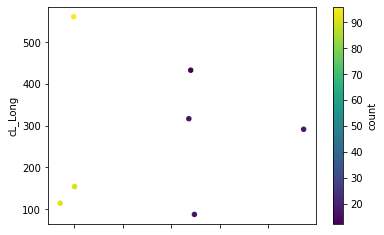

In [81]:
plot_bygroup_df.plot.scatter(x='cL_Lat',y='cL_Long',c='count',colormap='viridis')

In [82]:
plot_df[['cL_Lat', 'cL_Long']].dropna()

,cL_Lat,cL_Long
0,298.481481,561.222222
1,298.481481,561.222222
2,298.481481,561.222222
3,298.481481,561.222222
4,298.481481,561.222222
...,...,...
347,298.481481,561.222222
348,298.481481,561.222222
349,298.481481,561.222222
350,298.481481,561.222222


In [83]:
nonNAN_index = plot_df[['cL_Lat', 'cL_Long']].dropna().index

In [84]:
X = np.array(plot_df.iloc[nonNAN_index,:][['cL_Lat', 'cL_Long']] )

In [85]:
len(nonNAN_index)

340

In [86]:
X[60]

array([539.83333333, 433.16666667])

In [87]:
X.shape

(340, 2)

In [88]:
type(X[0,0])

numpy.float64

In [89]:
 np.isfinite(X).all()

True

In [90]:
X.shape

(340, 2)

In [91]:
int(np.ceil(X.shape[0]/50))

7

In [92]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(np.ceil(X.shape[0]/50)), random_state=0).fit(X)

In [93]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6,
       6, 1, 6, 1, 6, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5,
       2, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

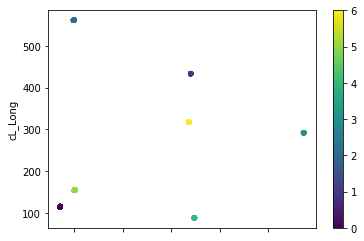

In [94]:
plot_df.iloc[nonNAN_index,:].plot.scatter(x='cL_Lat',y='cL_Long',c=kmeans.labels_,colormap='viridis')

### KMean cluster does not allow us to set the maximum number of tags per cluster. ASi gateways limits 60 devices per gateway which means there needs to be an inherent maximum point in cluster limit we can allow per cluster. For this, we will modify DBScan clustering algorithm. DBScan algorithm is used since density is already a factor in the algoritm itself. The cluster grow until it reaches the edge.

### With DBScan algorithm, we can limit the cluster growth once the overall cluster point limit has been reached. We will achieve this by conditionally the FOR loop that handles cluster growth. Once maximum cluster point limit has been reached, we will simply return the unassigned points from the current cluster back to the original neighbor search list. This allows each point to be explored by the algorithm even if they are not an edge to a cluster. 

In [95]:
from dbscan import MyDBSCAN
from sklearn.preprocessing import StandardScaler

In [96]:
X.shape

(340, 2)

In [97]:
X_normalized = StandardScaler().fit_transform(X)

In [98]:
X_normalized

array([[-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [-0.37129193,  1.47161673],
       [ 3.29061087,  0.06249432],
       [ 3.29061087,

In [99]:
print ('Running my implementation...')
my_labels = np.array(MyDBSCAN(X_normalized, eps=.4, MinPts=20, MaxPts = 60))

Running my implementation...
{}
Growing Cluster
{1: 61}
Growing Cluster
Completed
{1: 61, 2: 54}
Growing Cluster
Completed
{1: 61, 2: 54, 3: 17}
Growing Cluster
Completed
{1: 61, 2: 54, 3: 29}
Growing Cluster
Completed
{1: 61, 2: 54, 3: 45}
Growing Cluster
{1: 61, 2: 54, 3: 61}
Growing Cluster
{1: 61, 2: 54, 3: 61, 4: 61}
Growing Cluster
{1: 61, 2: 54, 3: 61, 4: 61, 5: 61}
Growing Cluster
Completed


In [100]:
core_samples_mask = np.zeros_like(my_labels, dtype=bool)
core_samples_mask[np.array(range(0,len(my_labels)))] = True
labels = my_labels

In [101]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]


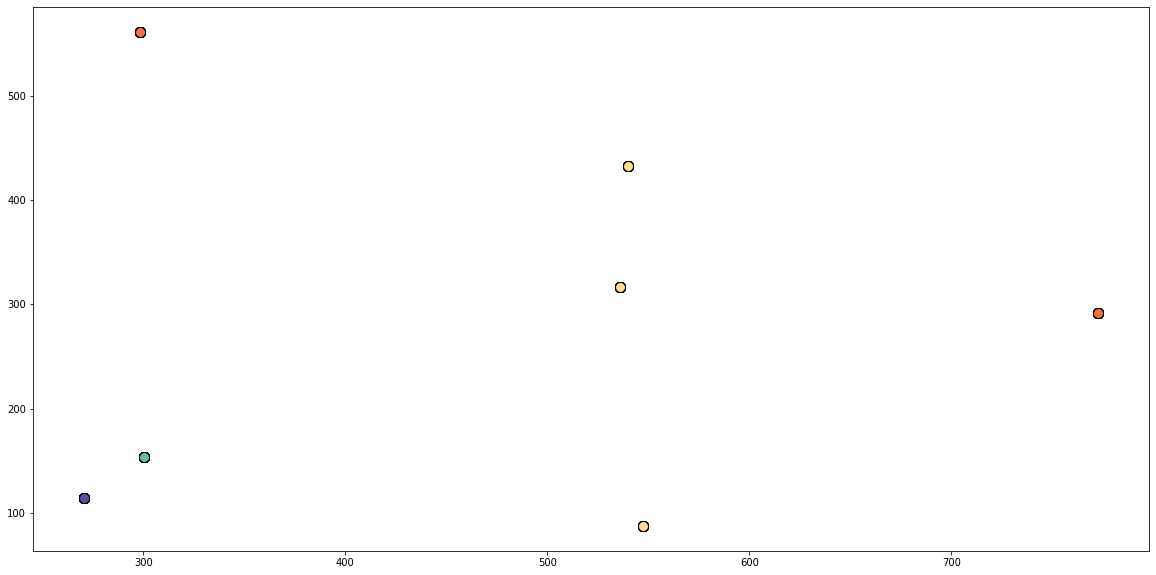

In [102]:
plt.figure(figsize=(20,10)) 
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    #print(k)
    class_member_mask = (my_labels == k)
    #print(my_labels == k)
    xy = X[class_member_mask & core_samples_mask]
    #print(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    #print(xy)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [103]:
clusterDict = {}
for label in labels:
    if label in clusterDict.keys():
        clusterDict[label] += 1
    else:
        clusterDict[label] = 1

In [104]:
check_result_df.iloc[nonNAN_index,:].shape[1]

13

In [105]:
dbscan_labeled = check_result_df.iloc[nonNAN_index,:]
dbscan_labeled["Gateway_Label"] = my_labels

C:\Users\ZhZou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [106]:
clusterDict

{1: 60, 2: 53, 3: 60, 4: 60, 5: 60, 6: 47}

### Run with max size 240
#### {1: 96, 2: 17, 3: 16, 4: 12, 5: 16, 6: 183}

In [107]:
my_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5,
       1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#### Taking a closer look at individual cluster grouping

In [112]:
dbscan_labeled[['DWG Number', 'Gateway_Label', 'Tag','unit_label',
       'cL_Lat', 'cL_Long']].sort_values(by=['cL_Lat','cL_Long']).iloc[185:285,:]

,DWG Number,Gateway_Label,Tag,unit_label,cL_Lat,cL_Long
349,PID-142,2,20-ZSC/O-4104E,None,298.48148148148147,561.2222222222222
350,PID-142,2,20-ZIS-4103J,None,298.48148148148147,561.2222222222222
351,PID-142,2,20-ZSC-4105A,None,298.48148148148147,561.2222222222222
100,PID-121,3,20-ZIS-2106J,5,300.3809523809524,154.1904761904762
101,PID-121,3,20-XY-2108A,5,300.3809523809524,154.1904761904762
102,PID-121,3,20-ZIS-2108K,5,300.3809523809524,154.1904761904762
103,PID-121,3,20-XY-2108P,5,300.3809523809524,154.1904761904762
104,PID-121,3,20-XY-2106E,5,300.3809523809524,154.1904761904762
105,PID-121,3,20-ZSC-2106A,5,300.3809523809524,154.1904761904762
106,PID-121,3,20-ZSO-2107H,None,300.3809523809524,154.1904761904762


### Performance Evaluation:

#### The performance of the clustering algorithm can be judged by how close it is to the human generated instrument cluster group. In the program itself, this evaluation will not be part of the learning process. Here in the experimental phase of program development, we wish to evaluate equivalent purpose algorithms in order to choose the best performing algorithm for the final application.

#### Completeness and Homogeneity will be the metrics used to evaluate the effectiveness of the clustering algoritm

In [109]:
from sklearn.metrics import completeness_score, homogeneity_score